In [23]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import signal
from scipy import constants
import os
import glob
from matplotlib import rc

from influxdb import InfluxDBClient, DataFrameClient
class InfluxData:
    def __init_(self):
        self._cli = None;
        self._devices = []
        self._rs = None;
    def set_client(self,ip,port:int,ID,pwd,database):
        self._cli = InfluxDBClient(ip,port,ID,pwd,database=database)
        if self._cli is None:
            print("Client Connect fail!")
            return
        return self
    def get_device(self):
        if self._cli is None:
            print("Client Connect fail!")
            return
        self._rs = self._cli.query("show series")
        self._devices = list(map(lambda x: x[0].split('=')[1], self._rs.raw['series'][0]['values']))
        return self._devices
    def query(self,qry:str):
        try:
            self._rs = self._cli.query(qry)
        except:
            print("cannot query to influxDB")
            raise
        return self
    def resultSetToDF(self):
        # Convert query resultset to DataFrame
        return DataFrameClient()._to_dataframe(rs=self._rs)
        

In [24]:
from InfluxData import InfluxData
client = InfluxData()
client.set_client('155.230.28.170',8086,'sslab','1231',database='kmaeq')
device_ids = client.get_device()

In [40]:
EXPECT_DATASET_SIZE = 60000 # 10min data
#for dev_id in device_ids:
def visualization(dev_id):
    rs = client.query(f"select * from acc_data where dev_id='{dev_id}' and time >= '2019-04-02T00:00:00Z' AND time <= '2019-04-03T00:00:00Z'")
    data = client.resultSetToDF(rs=rs)
    if type(data['acc_data']) is list: #  it means empty data
        return
    if len(data['acc_data']) < EXPECT_DATASET_SIZE*0.9: # not enough data size
        return
    data = data['acc_data'] # convert dict_dataframe to dataframe
    timeidx= data.index
    time_interval = []
    time_map = {}
    for i in range(1,timeidx.size):
        diff = (timeidx[i]-timeidx[i-1]).total_seconds()
        try:
            time_map[diff] += 1
        except:
            time_map[diff] = 1
    x_ax = list(time_map.keys())
    y_ax = []
    for i in x_ax:
        y_ax.append(time_map[i])
    fig, ax = plt.subplots()
    ax.bar(x_ax,y_ax,width=0.001)
    # fig.savefig('./time_interval_img_0402/'+str(dev_id)+'_tsDiff'+'_0402',dpi=300)
    fig.show()

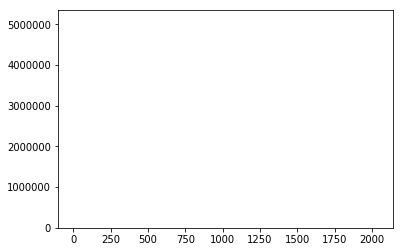

In [44]:
visualization('0015')

In [37]:
from concurrent.futures import ProcessPoolExecutor
with ProcessPoolExecutor(os.cpu_count() * 4) as proc:
    for dev_id in device_ids:
        proc.submit(visualization,dev_id)

In [38]:
os.getcwd()

'/home/knusslab/Sang/data'